# Image recognition with TTR


In [1]:
import sys
sys.path.append('pyttr')
from pyttr.ttrtypes import *
from pyttr.utils import *
import PIL.Image

In [2]:
Ind = BType('Ind')

## Utilities & PyTTR additions

In [3]:
# Can be called with multiple args *at the end* of a code block to illustrate PyTTR types and objects.
def latex(*objs):
    texcode = '\n\n'.join(to_ipython_latex(obj) for obj in objs)
    #print(texcode) # Uncomment to get LaTeX source.
    return Latex(texcode)

# Redefine Image.show() to work with Rec.show().
def image_show(self):
    return str(self)
PIL.Image.Image.show = image_show

### Custom PyTTR utilities

Several changes have also been made inside the PyTTR lib, regarding relabeling, subst and latex. They currently live on separate branches at https://github.com/arildm/pyttr.

In [4]:
def rectype_relabels(T, rlbs):
    """Relabel multiple fields, given a dict of from-to pairs."""
    T = T.copy()
    # Add a temporary label to each pair, to avoid overwriting.
    # This is not a guard against {a:c, b:c}, but against {a:b, b:c}.
    rlbs = [(l1, l2, gensym('rlb')) for l1, l2 in rlbs.items()]
    # First relabel all fields to tmp labels, then all to desired labels.
    for l1, l2, l_tmp in rlbs:
        T.Relabel(l1, l_tmp)
    for l1, l2, l_tmp in rlbs:
        T.Relabel(l_tmp, l2)
    return T

def is_basic_type(T):
    """Whether a type is a "basic field", i.e. a BType or a SingletonType of a BType."""
    tn = lambda T: type(T).__name__
    return (tn(T) == 'BType') if tn(T) != 'SingletonType' else is_basic_type(T.comps.base_type)

def basic_fields(T):
    """The labels of basic fields in a RecType."""
    return [k for k, v in T.fields() if is_basic_type(v)]

def nonbasic_fields(T):
    """The labels of non-basic fields in a RecType."""
    return [k for k, v in T.fields() if not is_basic_type(v)]

In [5]:
T = RecType({'a': 1, 'b': 2, 'c': 3})
# Valid relabeling; is handled.
print(show(rectype_relabels(T, {'a': 'b', 'b':'d'})))
# Invalid relabeling; fails. Fix your usage.
print(show(rectype_relabels(T, {'a': 'c', 'b':'c'})))

{b : 1, c : 3, d : 2}
{c : 1}


In [6]:
# mkptype saves the created PType objects. If called a second time with the same pred and vars,
# the existing object is returned, instead of instantiating PType every time.
ptypes = dict()
def mkptype(sym, types=[Ind], vars=['v']):
    """Make preds and ptypes identifiable by their predicate names."""
    id = '/'.join([sym, ','.join(show(type) for type in types), ','.join(vars)])
    if id not in ptypes:
        ptypes[id] = PType(Pred(sym, types), vars)
    return ptypes[id]

def create_fun(pred_name, vars=['a']):
    """Create a function of a given number of Inds (length of vars).
    
    Example: create_fun('give', 'abc') --> \a. \b. \c. give(a, b, c)
    """
    fun = mkptype(pred_name, types=[Ind]*len(vars), vars=vars)
    for v in reversed(vars):
        fun = Fun(v, Ind, fun)
    return fun

latex(create_fun('give', 'abc'))

<IPython.core.display.Latex object>

In [7]:
def use_ind_field_labels(T):
    """c:foo(a) becomes c:foo(x) if x=a:Ind is present."""
    T = T.copy()
    for l, v in T.fields():
        if isinstance(v, SingletonType) and v.comps.base_type == Ind:
            a = v.comps.obj
            T.Relabel(a, l)
            # Undo the relabeling of the Ind field itself.
            T.comps.__dict__[l] = SingletonType(Ind, a)
    return T

T = RecType({'x': SingletonType(Ind, 'a'), 'c': (create_fun('foo', 'v'), ['a'])})
latex(T, use_ind_field_labels(T))

<IPython.core.display.Latex object>

In [8]:
def unsingleton(T):
    """Remove singleton specifications of a type: x=a:Ind becomes x:Ind."""
    T2 = RecType()
    for l, v in T.fields():
        T2.addfield(l, v if not isinstance(v, SingletonType) else v.comps.base_type)
    return T2

T = RecType({'x': SingletonType(Ind, 'a')})
latex(T, unsingleton(T))

<IPython.core.display.Latex object>

In [111]:
from itertools import repeat

def dedupe(T):
    """Make a copy of a record type without duplicated field values."""
    for l,v in T.fields():
        # Are there more fields with the same value?
        l2s = [l2 for l2,v2 in T.fields() if l2 != l and show(v) == show(v2)]
        if len(l2s):
            # Relabel all these fields to the same label, overwriting until one remains.
            for l2 in l2s:
                T.Relabel(l2, l)
            # Dependent fields have changed, so start over.
            return dedupe(T)
    # No more duplicates.
    return T

T = RecType({
    'x': SingletonType(Ind, 'a'),
    'y': SingletonType(Ind, 'a'),
    'c': (create_fun('foo'), ['x']),
    'd': (create_fun('foo'), ['y']),
})
latex(T, dedupe(T.copy()))

<IPython.core.display.Latex object>

In [80]:
T = RecType({'a': 'V', 'b': 'V'})
T.Relabel('a', 'b')
show(T)

'{b : V}'

In [9]:
class LambdaFun(Fun):
    """Models a unary Python function as a TTR function."""
    def __init__(self,dom,body, example=None):
        self.__setattr__('domain_type',dom)
        self.__setattr__('body',body)
        self.__setattr__('example', example)
    def show(self):
        return 'lambda r' + ':' + self.domain_type.show() + ' . ' + self.body.__name__ + '(r)'
    def to_latex(self):
        return '\\lambda r' + ':' + self.domain_type.to_latex() + '\\ .\\ ' + self.body.__name__ + '(r)'
    def validate(self):
        return isinstance(self.domain_type,Type)

    def app(self,arg):
        # Type/subtype checking will use hypobjs, which may cause problems because the
        # Python function expects a real object. Such functions should supply an 'example'
        # input in the constructor, which is then substituted for a hypobj arg here.
        # @TODO Does this make sense?
#         if self.example is not None and is_hypobj(arg):
#             arg = self.example
        
        res = self.body(arg)
        if 'eval' in dir(res):
            return res.eval()
        else:
            return res

    def is_hypobj(r):
        return isinstance(r, HypObj) or \
            (isinstance(r, Rec) and forsome([v for l,v in r.fields()], self.is_hypobj))

    def subst(self,v,a):
        return self

P = FunType(Ind, Ty)
T = RecType({'f': P})
def on_a(r):
    return RecType({'c': (r.f, 'z')})
fun = LambdaFun(T, on_a)
print(show(fun.app(Rec({'f': create_fun('dog')}))))

# # With hypobj. @TODO ?
# F = FunType(T, RecTy)
# print(F.query(fun))

{c : (lambda a:Ind . dog(a), z)}


# Types

$Ind$ and $Image$ are basic types.

$Segment = \left[\begin{array}{rcl}
\text{cx} &:& Int\\
\text{cy} &:& Int\\
\text{w} &:& Int\\
\text{h} &:& Int\\
\end{array}\right]$

$Ppty = (Ind \rightarrow Type)$

$Obj = \left[ \begin{array}{rcl}
    \text{pfun} &:& Ppty \\
    \text{seg} &:& Segment \\
\end{array} \right]$

$ObjDetector = ( Image \rightarrow [Obj] )$

$IndFun = ( Obj \rightarrow RecType )$

## Bridging between perceptual and conceptual domains

Let's apply the object detection representation proposed in Dobnik & Cooper's *Interfacing language, spatial perception and cognition in TTR* to image recognition.

![Fig 8](fig/lspc-fig8.png)

Here, we use `Image` instead of `PointMap` for the whole, but instead of `reg:PointMap` we use yet another type (and rename it), `seg:Segment`. In Cooper's case the same type can be used to represent both the region and the whole, because a `PointMap` is a set of absolute positions. With `Image`, positions are relative to an origin, which needs to be specified when cropping.

I guess in the general case, the domain of an `ObjectDetector` function need not be the same as the `reg` fields in the output elements.

In [10]:
# More basic types.

Int = BType('Int')
Int.learn_witness_condition(lambda x: isinstance(x, int))
print(Int.query(365))

Image = BType('Image')
Image.learn_witness_condition(lambda x: isinstance(x, PIL.Image.Image))
img = PIL.Image.open('res/dogride.jpg') # https://www.flickr.com/photos/hickatee/34017375600
print(Image.query(img))

# Segment type: a rectangular area of a given image.

Segment = RecType({'cx': Int, 'cy': Int, 'w': Int, 'h': Int})
print(Segment.query(Rec({'cx': 100, 'cy': 150, 'w': 40, 'h': 20})))

True
True
True


In [11]:
Ppty = FunType(Ind, Ty)
Obj = RecType({'seg': Segment, 'pfun': Ppty})
Objs = ListType(Obj)
ObjDetector = FunType(Image, Objs)

latex(Segment, Ppty, ObjDetector)

<IPython.core.display.Latex object>

## Object detection model YOLO

We use an object detection model to detect and recognize objects in an image. The output is modeled as a set of TTR records.

Requires OpenCV and [Darkflow](https://github.com/thtrieu/darkflow). `yolo.weights` is from [Yolo](https://pjreddie.com/darknet/yolo/).

In [12]:
# Instantiate YOLO.

from darkflow.net.build import TFNet

tfnet = TFNet({"model": "yolo/yolo.cfg", "load": "yolo/yolo.weights",
    'config': 'yolo', "threshold": 0.2})

Parsing yolo/yolo.cfg
Loading yolo/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.054228782653808594s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +b

In [13]:
# Function to apply YOLO to a given image.

import numpy as np

yolo_out = dict()
def yolo(img):
    """Invokes YOLO on a PIL image, caches and returns the result."""
    if str(img) not in yolo_out:
        res = tfnet.return_predict(np.array(img))
        # Save the most confident detections.
        res.sort(key=lambda o: -o['confidence'])
        yolo_out[str(img)] = res[:7]
    return yolo_out[str(img)]

def yolo_coords(o):
    """Extract the coordinates from a YOLO output item as ((x0,y0), (x1,y1))."""
    return (o['topleft']['x'], o['topleft']['y']), (o['bottomright']['x'], o['bottomright']['y'])

def xy1xy2_to_cwh(x1, y1, x2, y2):
    '''Transform to center, width and height.'''
    return {'cx': int(x1/2 + x2/2), 'cy': int(y1/2 + y2/2), 'w': x2 - x1, 'h': y2 - y1}

def yolo_reformat(o):
    """Discards the confidence item and reformats the coordinates."""
    return {'label': o['label'],
        'loc': xy1xy2_to_cwh(*sum(yolo_coords(o), ()))}

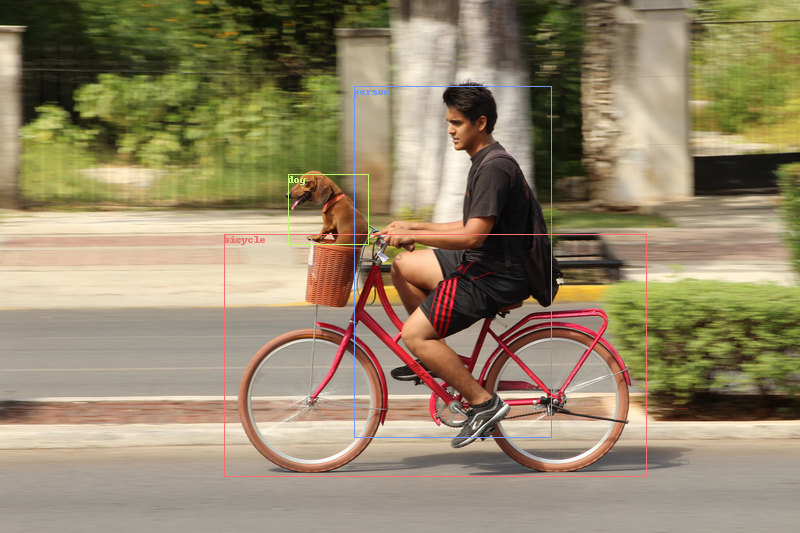

In [14]:
from PIL import ImageFont, ImageDraw
from IPython.display import display

# Generate distinguishable colors.
phi = 2 / (1 + 5 ** .5)
colors = ('hsl({}, 90%, 70%)'.format(int(x * 360)) for x in count(0, phi))

def yolo_annotate(img):
    """Displays the image with YOLO results annotated."""
    img_annotated = img.copy()
    draw = ImageDraw.Draw(img_annotated)
    for o in yolo(img):
        color = next(colors)
        draw.rectangle(yolo_coords(o), outline=color)
        draw.text(yolo_coords(o)[0], o['label'], fill=color)
    display(img_annotated)
    
yolo_annotate(img)
# Modified image under licence CC-by-nc-sa: https://creativecommons.org/licenses/by-nc-sa/2.0/

In [15]:
# Representing detected objects in TTR.

def yolo_detector(i):
    """Creates IndObj records for YOLO results."""
    for o in yolo(i):
        o = yolo_reformat(o)
        yield Rec({
            'seg': Rec(o['loc']),
            'pfun': create_fun(o['label'].replace(' ', '_')),
        })
ObjDetector.witness_cache.append(yolo_detector)

objs = list(yolo_detector(img))

print(ObjDetector.query(yolo_detector))
print(Objs.query(objs))
print(Obj.query(objs[0]))
print(Ppty.query(objs[0].pfun))
print(Segment.query(objs[0].seg))

latex(objs)

True
True
True
True
True


<IPython.core.display.Latex object>

## Individuation function

The object detection model gave us evidence that certain segments contain something that present certain properties/classes.

Now let's recognize that there are individuals which are located at those segments and having those properties. ("Basic relationships" in Logan & Sadler (1996)).

$IndObj = \left[\begin{array}{rcl}
\text{x} &:& Ind\\
\text{cp} &:& Type\\
\text{cl} &:& \text{location}(\text{x}, \text{loc})\\
\text{loc} &:& Segment\\
\end{array}\right]$

$f_{IndFun} : IndFun$

$IndFun = (Obj \rightarrow RecType)$

$f_{IndFun} = \lambda r : Obj\ . \left[\begin{array}{lcl}
    \text{x} = a_0 &:& Ind \\
    \text{cp} = e_0 &:& r.\text{pfun}(\text{x}) \\
    \text{cl} = e_1 &:& \text{location}(\text{x}, \text{loc}) \\
    \text{loc} = r.\text{seg} &:& Segment\\
\end{array}\right]$

In [16]:
PTy = Type('PTy')
PTy.learn_witness_condition(lambda p: isinstance(p, HypObj) \
    and forsome(p.types, lambda t: isinstance(t, PType)))

location_ptype = mkptype('location', [Ind, Segment], ['k', 'l'])
cl_fun = Fun('k', Ind, Fun('l', Segment, location_ptype))

IndObj = RecType({
    'x' : Ind,
    'loc' : Segment,
    'cp' : PTy,
    'cl' : (cl_fun, ['x', 'loc']),
})
IndFun = FunType(Obj, RecTy)

def indfun(r):
    if not Obj.query(r):
        raise ValueError()
    indobj = RecType({
        'x': SingletonType(Ind, Ind.create()),
        'cp': (r.pfun, ['x']),
        'loc': SingletonType(Segment, r.seg),
        'cl': (cl_fun, ['x', 'loc']),
    })
    if not unsingleton(indobj).subtype_of(IndObj):
        raise ValueError()
    return indobj
IndFun.witness_cache.append(indfun)

indobjs = [indfun(r) for r in objs]

print(Obj.query(objs[1]))
print(RecTy.query(indobjs[1]))
print(unsingleton(indobjs[1]).subtype_of(IndObj))
print(IndObj.query(indobjs[1].create_hypobj()))
latex(indobjs)

True
True
True
True


<IPython.core.display.Latex object>

## Spatial relations

Classify two $IndObj$s as $\text{left}$:

$LocTup = \left[\begin{array}{rcl}
    \text{lo} &:& IndObj \\
    \text{refo} &:& IndObj \\
\end{array}\right]$

$RelClf = (LocTup \rightarrow Type)$

For some classifier $\kappa$ and predicate $pred$,

$\lambda r : LocTup .
\begin{cases}
\left[\begin{array}{lcl}
    \text{cr} &:& pred(r.\text{lo}.\text{x}, r.\text{refo}.\text{x})\\
\end{array}\right]
&
\begin{array}{l}
    \text{if } \kappa(r.\text{lo}.\text{loc}, r.\text{refo}.\text{loc}) \\
\end{array}\\
[] & \text{otherwise}
\end{cases}
$

In [60]:
from itertools import product

LocTup = RecType({'lo': IndObj, 'refo': IndObj})
RelClf = FunType(LocTup, RecTy)

location_relation_classifiers = {
    'left': lambda a, b: a.cx < b.cx,
    'right': lambda a, b: a.cx > b.cx,
    'above': lambda a, b: a.cy < b.cy,
    'below': lambda a, b: a.cy > b.cy,
}

def relclf(r, pred, f):
    # Support type checking of this function, which uses HypObj.
    if isinstance(r.lo.loc.cx, HypObj):
        return RecType()
    # @TODO Why not? IndObj.query(r.lo) and IndObj.query(r.refo)
    if f(r.lo.loc, r.refo.loc):
        c = create_fun(pred, 'ab')
        return RecType({
            'x': SingletonType(Ind, r.lo.x),
            'y': SingletonType(Ind, r.refo.x),
            'cr': (c, ['x', 'y']),
        })
    return RecType()

def get_relclfs():
    relclfs = []
    for pred, f in location_relation_classifiers.items():
        relclfs.append(lambda r, pred=pred, f=f: relclf(r, pred, f))
    return relclfs

relclfs = [LambdaFun(LocTup, relclf) for relclf in get_relclfs()]

loctups = []
def find_all_rels(indobjs):
    """Find all relations between IndObj records."""
    for relclf in relclfs:
        for loT, refoT in product(indobjs, indobjs):
            loctup = Rec({'lo': loT.create(), 'refo': refoT.create()})
            loctups.append(loctup)
            yield relclf.app(loctup)
        
rels = list(rel for rel in find_all_rels(indobjs) if len(rel.labels()) > 0)

latex(rels)

<IPython.core.display.Latex object>

## Combining commitments

We have now observed basic relation situations ($IndObj$s) as well as deictic relation situations (binary spatial relations). They are now combined into one, so they can be considered simultaneously.

The "classical" way (Cooper 2016, TTL) is to nest each record type inside the next, under a _prev_ label, and then flatten it.

Here I use another method which is more efficient but not as TTR-pure. Each record type is merged into a new, accumulated record type, after giving each field a new unique label.

@TODO Why do we need unique labels? Without it we will have a lot of _meets_, but maybe that's not bad?

In [66]:
# The classical method using nesting and flattening.

from functools import reduce

Prev = LambdaFun(RecTy, lambda old:
         LambdaFun(RecTy, lambda new:
           RecType({'prev': old}).merge(new)))

def combine_prev(Ts):
    return reduce(lambda old, new: Prev.app(old).app(new), Ts, RecType()).flatten()
    
# Shorten labels just to inspect the result without a thousand "prev"s
def relabel_short(T):
    return rectype_relabels(T.copy(), dict(((l, gensym('r')) for l in T.labels())))

In [67]:
# Custom method with unique labels before merging.

from functools import reduce

def unique_labels(T):
    """Relabel a RecType so each field label is unique over all RecTypes."""
    return rectype_relabels(T, dict((l, gensym(l)) for l in T.labels() if '_' not in l))

def merge_unconflict(T1, T2):
    """Merge two RecTypes after making sure they do not share any field labels."""
    return unique_labels(T1).merge(unique_labels(T2))
    
MergeUnconflict = LambdaFun(RecTy, lambda a: LambdaFun(RecTy, lambda b: merge_unconflict(a, b)))

def combine_unconflict(Ts):
    """Combine a list of belief record types into one."""
    return reduce(lambda a, b: MergeUnconflict.app(a).app(b), Ts, RecType())

In [112]:
bel = indobjs + rels

# combine_method = combine_prev
combine_method = combine_unconflict

def combine(Ts):
    Ts = [T for T in Ts if len(T.labels()) > 0]
    return dedupe(combine_method(Ts))

bel_comb = combine(bel)

latex(relabel_short(bel_comb))
# latex(bel_comb)

<IPython.core.display.Latex object>

## Text parsing

In [23]:
import nltk
from nltk.sem.logic import ApplicationExpression, AndExpression, ExistsExpression, ConstantExpression

# Parsing to PyTTR cannot really be done directly. NLTK feature grammars support strings and FOPC. Variable substitution
# is only allowed in FOPC. We produce a FOPC conjunction of ptypes, for each of which we create a new field.
grammar = nltk.grammar.FeatureGrammar.fromstring(r'''
%start S
S[SEM=<?s(?vp)>] -> NP[SEM=?s] VP[SEM=?vp]
S[SEM=?q] -> QS[SEM=?q]
QS[SEM=<?s(?vp)>] -> 'is' 'there' NP[SEM=?s] PP[SEM=?vp]
QS[SEM=<?s(\P.true)>] -> 'is' 'there' NP[SEM=?s]

NP[SEM=<?det(?n)>] -> Det[SEM=?det] N[SEM=?n]
Det[SEM=<\P Q.exists x.(P(x) & Q(x))>] -> 'a' | 'an'

VP[SEM=?pp] -> 'is' PP[SEM=?pp]
PP[SEM=<\s.(?o(\o.?prep(s, o)))>] -> Prep[SEM=?prep] NP[SEM=?o]

Prep[SEM=<left>] -> 'to' 'the' 'left' 'of'
Prep[SEM=<right>] -> 'to' 'the' 'right' 'of'
Prep[SEM=<above>] -> 'above'
Prep[SEM=<below>] -> 'below'
N[SEM=<aeroplane>] -> 'aeroplane'
N[SEM=<backpack>] -> 'backpack'
N[SEM=<bicycle>] -> 'bicycle'
N[SEM=<car>] -> 'car'
N[SEM=<dog>] -> 'dog'
N[SEM=<giraffe>] -> 'giraffe'
N[SEM=<kite>] -> 'kite'
N[SEM=<person>] -> 'person'
N[SEM=<snowboard>] -> 'snowboard'
N[SEM=<tent>] -> 'tent'
N[SEM=<tree>] -> 'tree'
''')
parser = nltk.FeatureChartParser(grammar)

texts = [
    'A dog is to the left of a bicycle',
    'Is there a dog to the left of a bicycle?',
    'Is there a person?',
]

def fopc_to_pyttr(expr, T=RecType()):
    """Turns a FOPC object into a RecType."""
    # Existential quantifier -> Ind field.
    if isinstance(expr, ExistsExpression):
        T.addfield(str(expr.variable), Ind)
        return fopc_to_pyttr(expr.term, T)
    
    # Application -> ptype, e.g. left(x, y)
    if isinstance(expr, ApplicationExpression):
        pred, args = expr.uncurry()
        # Create a PType function, e.g. lambda x:Ind . dog(x)
        fun = create_fun(str(pred), 'abcd'[:len(args)])
        T.addfield(gensym('c'), (fun, [str(a) for a in args]))
        return T
    
    # For and-expressions, interpret each term.
    if isinstance(expr, AndExpression):
        fopc_to_pyttr(expr.first, T)
        fopc_to_pyttr(expr.second, T)
        return T
    
    # A constant function in the "is there an X" rule trivially gives "true".
    if isinstance(expr, ConstantExpression) and str(expr.variable) == 'true':
        return T
    
    raise ValueError('Unknown expression: ' + str(type(expr)) + ' ' + str(expr))

def eng_to_pyttr(text):
    # Tokenize.
    sent = text.lower().strip('.?!').split()
    # NLTK-parse to syntax tree.
    trees = parser.parse(sent)
    # Extract semantic representation for the tree.
    sem = nltk.sem.root_semrep(list(trees)[0])
    # Interpret to TTR record type.
    T = fopc_to_pyttr(sem, RecType())
    return T

print(texts[1])
q = eng_to_pyttr(texts[1])
latex(q)

Is there a dog to the left of a bicycle?


<IPython.core.display.Latex object>

## Checking text against image

Essentially, we would like to check if the situation observed is a subtype of the situation described by the text/question, whether $Q \sqsupseteq A$. A new problem here is that field labels do not match, even if the field values (the types) match. We thus need to consider all (?) relabelings of Q:

A record type $T_1$ is a *relabel-subtype* of $T_2$ if there is a relabeling of $T_1$, $T_{1_{rlb}}$ where $T_{1_{rlb}} \sqsubseteq T_2$.

Could we forget field labels and just look at the two sets of field values? Not really, because we have dependent types, so $\text{dog}(x_1) ≠ \text{dog}(x_2)$. We need to carry out each candidate *relabeling* and check subtypeness. In practice, and in this case, relabeling the basic-type ($Ind$) fields is enough, because those are the only ones whose labels appear in dependent fields. For each basic-field relabeling, we can then kind of forget labels and just find subtypeness of field values.

### Algorithm: find-subtype-relabeling(T : RecType, U : RecType)

Prerequisites:

* Any dependent fields depend only on basic (non-dependent) fields (basic or singleton type)
* No nested record types (this could be solved using flattening but it's not needed in this scope)

Algorithm:

1. For each basic-field relabeling of U:
    1. For each complex field in U:
        1. Find a subtype field in T and remember it
        2. If no subtype field was found, skip to next basic-field relabeling
    2. A subtype T field was found for all complex U fields; return the relabeling
2. Return nothing

In [24]:
from itertools import permutations, combinations

def my_subtype_of(sub, sup):
    """Is T a subtype of U? Accept dependent rectype fields (= (fun, args) tuples) with simplistic equality test."""
    try:
        return sub.subtype_of(sup)
    except AttributeError:
        return isinstance(sub, tuple) and isinstance(sup, tuple) and show(sub) == show(sup)

def find_subtype_relabeling(S, Q):
    '''Could record type S be a sub type of record type Q if relabeling in Q is allowed?'''
    # For each relabeling of basic-type fields
    for sls in permutations(basic_fields(S), len(basic_fields(Q))):
        # Try the basic-fields relabeling of Q
        rlb_basic = dict(zip(basic_fields(Q), sls))
        Q2 = rectype_relabels(Q, rlb_basic)
        
        # For each Q field, find a S field that is a subtype
        rlb_dep = dict()
        for ql in nonbasic_fields(Q2):
            for sl in nonbasic_fields(S):
                # The new labels must be unique.
                if sl in rlb_dep.values(): continue
                if my_subtype_of(S.field(sl), Q2.field(ql)):
                    rlb_dep[ql] = sl
                    break
            if ql not in rlb_dep:
                break

        # Successful if all non-basic fields match.
        if len(rlb_dep) == len(nonbasic_fields(Q2)):
            return dict(**rlb_basic, **rlb_dep)
    return None

In [25]:
utts_rlb = []
for text in texts:
    q = eng_to_pyttr(text)
    rlb = find_subtype_relabeling(bel_comb, q)
    print(text + ' - ' + str(bool(rlb)))
    if rlb:
        utt_rlb = rectype_relabels(q, rlb)
        utts_rlb.append(utt_rlb)
latex(utts_rlb)

A dog is to the left of a bicycle - True
Is there a dog to the left of a bicycle? - True
Is there a person? - True


<IPython.core.display.Latex object>

# Agent state

We are building an agent who receives classified and located objects of an image, apprehends their basic status and spatial relations, and validates natural-language propositions.

The agent state is of the type $AgentState$. It contains sensory input records, belief rectypes and classification functions that can create new beliefs.

$Agent = \left[\begin{array}{rcl}
    \text{objdetector} &:& ObjDetector \\
    \text{indfun} &:& IndFun \\
    \text{relclfs} &:& [RelClf] \\
    \text{state} &:& AgentState \\
    \end{array}\right]$

$AgentState = \left[\begin{array}{rcl}
    \text{img} &:& Image \\
    \text{perc} &:& [Obj] \\
    \text{bel} &:& [RecType] \\
    \text{utt} &:& RecType \\
    \end{array}\right]$

In [26]:
AgentState = RecType({
    'img': Image,
    'perc': Objs,
    'bel': ListType(RecTy),
    'utt': RecTy,
})
Agent = RecType({
    'objdetector': ObjDetector,
    'indfun': IndFun,
    'relclfs': ListType(RelClf),
    'state': AgentState,
})
latex(Agent)

<IPython.core.display.Latex object>

In [27]:
st = Rec({
    'perc': [],
    'bel': [],
    'img': img,
    'utt': RecType(),
})
ag = Rec({
    'objdetector': yolo_detector,
    'indfun': indfun,
    'relclfs': relclfs,
    'state': st,
})

print(AgentState.query(st))
print(Agent.query(ag))

True
True


In [113]:
def agent_see(ag, img):
    if not Agent.query(ag): raise ValueError
    ag.state.img = img
    ag.state.perc = list(ag.objdetector(ag.state.img))
    ag.state.bel = [indfun(r) for r in ag.state.perc]
    
    for Ta, Tb in product(ag.state.bel, ag.state.bel):
        if Ta == Tb: continue
        loctup = RecType({'lo': Ta, 'refo': Tb})
        for relclf in ag.relclfs:
            ag.state.bel.append(relclf.app(loctup.create_hypobj()))
    if not Agent.query(ag): raise ValueError

def agent_hear(ag, text):
    if not Agent.query(ag): raise ValueError
    ag.state.utt = eng_to_pyttr(text)
    bel = combine(ag.state.bel)
    rlb = find_subtype_relabeling(bel, ag.state.utt)
    if not Agent.query(ag): raise ValueError
    return bool(rlb)

q = 'is there a person above a bicycle'
print('Q:', q)
agent_see(ag, img)
a = agent_hear(ag, q)
print('A:', a)

Q: is there a person above a bicycle
A: True


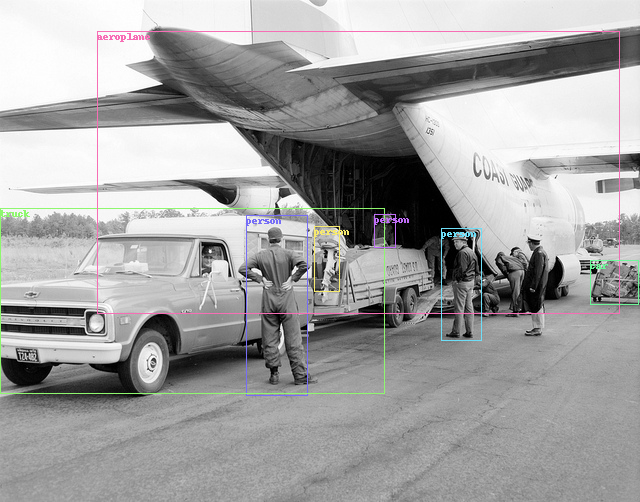

Is there an aeroplane? - Yes
Is there a person to the right of a car? - No


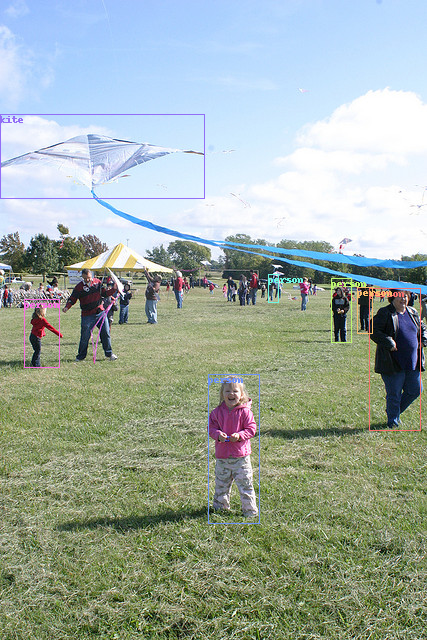

Is there a tent? - No
Is there a kite above a person? - Yes


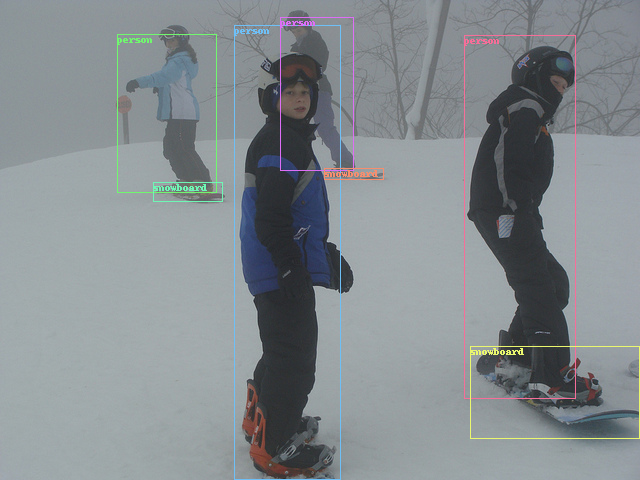

Is there a snowboard above a person? - Yes
Is there a snowboard below a person? - Yes


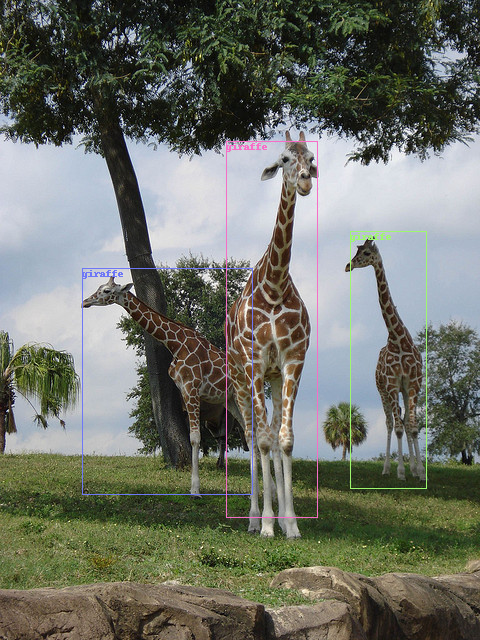

Is there a giraffe below a tree? - No


In [114]:
vqa_items = [
    {'imgpath': 'res/vqa1.jpg', 'questions': [
        'Is there an aeroplane?',
        'Is there a person to the right of a car?',
    ]},
    {'imgpath': 'res/vqa2.jpg', 'questions': [
        'Is there a tent?',
        'Is there a kite above a person?',
    ]},
    {'imgpath': 'res/vqa3.jpg', 'questions': [
        'Is there a snowboard above a person?',
        'Is there a snowboard below a person?',
    ]},
    {'imgpath': 'res/vqa4.jpg', 'questions': [
        'Is there a giraffe below a tree?',
    ]},
]

def vqa_eval(imgpath, questions):
    img = PIL.Image.open(imgpath)
    yolo_annotate(img)
    agent_see(ag, img)
    for question in questions:
        ans = 'Yes' if agent_hear(ag, question) else 'No'
        print(question + ' - ' + ans)
        
for item in vqa_items:
    vqa_eval(**item)